#Sequencing modeling
*   **Date**: 3/7/24
*   **Author**: Minxi
*   **Final Vesion**: 2.0


---



---

*   **Description**: This model quantitatively estimated the sequencing results from probe-capture-based targeted sequencing of viruses from wastewater background. The starting samples were the total RNA after extraction using the selected concentration/extraction method. It compared the impact of human virus/non-human virus mass ratio, different sequencing panels (including different probes), and the defined detection threshold on sequencing performance. The assumptions in this model includes:

  *   **Assumptions of initial condition in the extracted RNA**:
      *  A total of **5000 human RNA viruses** could be presented in the extracted RNA, **including SARS-CoV-2 and Mamastrovirus**, the rest background including non-human viruses (bacteriphages + plant viruses), bacteria, archaea, human cells etc..
      *  Human viruses includes **low, medium, and high abundances of viruses**, each following a different normal distribution of intial gc and genome lengts (see below for details).
      *  SARS-CoV-2 has an **initial gc of 5000** while Mamastrovirus has an **initial gc of 50000**.
      *   The mass ratio refers to the total mass ratio of 5000 human RNA viruses to non-viral background in the extracted RNA (**ranging from 1E-8 to 1E-1**).
      *   The molar mass of RNA is **321.5** and Da to ng is **1.66*1E-15**

  *   **Assumptions of the probe-capture sequencing**:
      *   Different panels include probes targeting different subset of the 5000 human viruses (see below for details). Those non-targeted viruses will be regarded as background
      *  Different panels have the same enrichment fold of the targeted viruses included in the panel (**X100** based on Rehn et al. 2021 paper), and each virus or anything (maybe the false positive sequences) that matches the same probe has the same enrichment fold regardless of its concentration in the sample
      *  Different panels have the same depletion fold for the non-targeted background (**X100** based on Rehn et al. 2021 paper). However, it's important to note that this calculation is based on a single wastewater background composition, and different wastewater compositions may result in varying depletion ratios in reality.
       *  The segment length after tagmentation step is **500 bp**, and the final reads length is **150 bp**.
       *  The targeted virus strains have no sequence overlap or redundancy.

  *   **Assumptions of virus coverage**:
   *  In Part 1 calculation, define the coverage requirement is **90%** coverage breadth of the virus genome and **10X** coverage depth





## Part 1: Predicting the virus relative abundances and required minimal sequencing depth


---



*   **Input**: virus/non-viral mass ratio, number of viruses included in the panel (panel size), distribution of intial virus gc and genome lengths in the extracted RNA, required genome coverage depth and breadth for each viruses
*   **Output**: Total targeted virus relative abundance%, Each targeted viruses relative abundance %, RPKM, and minimal sequencing depth (taken SARS-CoV-2 as an example)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Define constants
molar_mass_RNA = 321.5
Da_ng = 1.66 * 1E-15
segment_length = 500
enrichment_fold = 100
depletion_fold = 100
coverage_breadth=0.9
coverage_depth = 10

**Function 1**: Calculate the total gc and ng of all 5000 RNA
viruses in the extracted RNA

In [ ]:
import pandas as pd
import numpy as np

# Calculate the total gc of all 5000 human RNA viruses in the wastewater
def calculate_total_gc(gc_initials, genome_lengths, mass_ratio):
    ''' for all 5000 viruses, calculate total RNA virus gc and converted to ng using RNA molar mass and Da to ng conversion factors
    also calculate total gc and ng for virus and non-viral background based on set mass ratio
    '''
    # Calculate total 5000 RNA viruses ng
    virus_total_ng = 0
    for genome_length, gc_initial in zip(genome_lengths, gc_initials):
        virus_ng = (genome_length * gc_initial) * molar_mass_RNA * Da_ng
        virus_total_ng += virus_ng

    # Calculate total ng including 5000 viruses and non-viral background
    total_ng = (virus_total_ng / mass_ratio) + virus_total_ng
    total_gc = total_ng/(molar_mass_RNA*Da_ng)

    return virus_total_ng, total_ng, total_gc

**Function 2**: Calculate the total targeted virus ng, total non-targeted background ng, GC, and reads for the current panel (targeting only a subset of the 5000 viruses)

In [ ]:
def calculate_background_reads(selected_genome_lengths, selected_gc_initials,total_ng):
    ''' For each current panel, calculate the total targeted virus GC and convert it to ng.
        Then calculate the non-targeted background ng (including non-targeted viruses and non-viral background).
        Convert the non-targeted background ng to GC and calculate the final background reads after depletion.
    '''
    # calculate targeted_virus_ng
    targeted_virus_ng = sum(genome_length * gc_initial * molar_mass_RNA * Da_ng for genome_length, gc_initial in
                             zip(selected_genome_lengths, selected_gc_initials))
    non_targeted_virus_ng = virus_total_ng - targeted_virus_ng
    # Calculate the new background ng and reads for each subset size (including non-targeted viruses, and non-viral background)
    background_ng = total_ng - targeted_virus_ng
    background_gc = background_ng / (molar_mass_RNA * Da_ng)
    background_reads = (background_gc / segment_length) / depletion_fold

    return targeted_virus_ng, background_ng, background_gc, background_reads, non_targeted_virus_ng

**Function 3**: Calculate the total targeted virus relative abundance, total virus relative abundance, and the relative abundance and RPKM for each targeted virus

In [ ]:
def calculate_abundance_RPKM(selected_genome_lengths, selected_gc_initials, background_reads, targeted_virus_ng,non_targeted_virus_ng):
    '''For the current panel, calculate the total targeted virus reads after enrichment, and calculate the total targeted virus relative abundance
        Calculate the total virus reads (enriched targeted virus + depleted non-targeted virus) and corresponding relative abundance
        Finally calculated each targeted virus relative abundance and RPKM.
    '''
     # Calculate the total targeted virus reads for each subset
    total_targeted_virus_reads = sum((genome_length * gc_initial) / segment_length * enrichment_fold
                                     for genome_length, gc_initial in zip(selected_genome_lengths, selected_gc_initials))

    # Calculate total targeted viruses relative abundance
    total_targeted_virus_abundance = total_targeted_virus_reads / (background_reads + total_targeted_virus_reads) * 100

    # Calculate the total non-targeted virus reads
    non_targeted_virus_gc = non_targeted_virus_ng/(molar_mass_RNA * Da_ng)
    non_targeted_virus_reads = (non_targeted_virus_gc/segment_length)/depletion_fold

    # Calculate the total virus relative abundance
    total_virus_reads = total_targeted_virus_reads + non_targeted_virus_reads
    total_virus_abundance = total_virus_reads/(background_reads+total_targeted_virus_reads)*100

    relative_abundances = []
    rpkms = []

    # Calculate each virus relative abundance and RPKM
    for genome_length, gc_initial in zip(selected_genome_lengths, selected_gc_initials):
        Virus_reads = ((genome_length * gc_initial) / segment_length) * enrichment_fold
        relative_abundance = Virus_reads / (background_reads + total_targeted_virus_reads) * 100
        relative_abundances.append(relative_abundance)
        rpkm = (relative_abundance * 10000) / (genome_length / 1000)
        rpkms.append(rpkm)

    return total_targeted_virus_abundance, total_virus_abundance, relative_abundances, rpkms

**Function 4**: Calculate the minimal sequencing depth for detecting each viruses at the highest detection probability

In [ ]:
# calculate the sequencing_depth and the minimal sequencing depth for detecting at least one of the viruses included in the subset
def calculate_sequencing_depth(relative_abundances, selected_genome_lengths, coverage_breadth, coverage_depth):
  '''
  It return the
  final_sequencing_depth: minimal sequencing depth required to detect at least one viruses included in the panel
  Total sequencing depth: a list of the minimal sequencing depth required for at least one viruses (>0 relative abundace) to be detected
  '''
  total_sequencing_depths = []
  final_sequencing_depths = []
  for relative_abundance, genome_length in zip(relative_abundances, selected_genome_lengths):
          required_reads = genome_length * coverage_breadth * coverage_depth / relative_abundance
          total_sequencing_depths.append(required_reads)

          if relative_abundance != 0:
            required_reads_1 = genome_length * coverage_breadth * coverage_depth / relative_abundance
            final_sequencing_depths.append(required_reads_1)

  final_sequencing_depth = min(final_sequencing_depths)

  return final_sequencing_depth,total_sequencing_depths

# Input for calculation:

**Generating the 5000 viruses pool**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set random seed for reproducibility
np.random.seed(42)

# Add two additional viruses
SARS_CoV_2_gc = 5000
Mamastrovirus_gc = 50000
SARS_CoV_2_length = 30000
Mamastrovirus_length = 7000

# Generate random data for human virus initial gc
initial_gc_low = np.random.normal(loc=500, scale=500/3.5, size=999)  # mean 500, std 250, size 499 (low abundance human viruses like OC43)
initial_gc_medium = np.random.normal(loc=10000, scale=10000/3.5, size=2999)  # mean 10000, std 3000, size 499 (medium abundance human viruses like SARS-CoV-2)
initial_gc_high = np.random.normal(loc=25000, scale=25000/3.5, size=1000)  # mean 25000, std 12500, size 1499 (high abundance human viruses like panEV)
gc_initials_4998 = np.concatenate([initial_gc_low, initial_gc_medium, initial_gc_high])
gc_initials = np.concatenate([initial_gc_low, initial_gc_medium, initial_gc_high, [SARS_CoV_2_gc, Mamastrovirus_gc]])

# Generate random data for human virus genome length
genome_lengths_4998 = np.random.normal(loc=15000, scale=5000, size=4998)
genome_lengths = np.concatenate([genome_lengths_4998, [SARS_CoV_2_length, Mamastrovirus_length]])


In [ ]:
# Create DataFrame
data_human_virus = pd.DataFrame({
    'genome_length': genome_lengths,
    'initial_gc_human': gc_initials
})

## Generating the 4 different sequencing panels targeting different subsets of the 5000 viruses


*   The 2000 virus panel targeting a wider range of viruses including respiratory SARS-CoV-2 and enteric viruses Mamastrovirus, and other 1998 viruses randomly select from the 5000 viruses pool
*   The 200 virus panel targeting wide range viruses including respiratory SARS-CoV-2 and enteric viruses Mamastrovirus, and other 198 viruses randomly select from subset of the above 2000 virus panel
*   The 20 virus panel targeting Respiratory viruses including SARS-CoV-2 and another 19 viruses that might have similar intial gc level as SARS-CoV-2 (randomly select 19 viruses from the pool np.random.poisson(lam=100,60))
*   The 1 virus panel target SARS-CoV-2 virus staring with 30000 genome length and an initial gc of 500 gc.








In [ ]:
def generate_data(SARS_CoV_2_gc, SARS_CoV_2_length, Mamastrovirus_gc, Mamastrovirus_length, genome_lengths, gc_initials):
    # Generate the subset of large virus panel (2000) (contains both SARS-CoV-2 and Mamastrovirus, and other random 1998 viruses from the human virus pool)
    indices_4 = np.random.choice(len(genome_lengths_4998), 1998, replace=False)
    genome_lengths_4 = np.concatenate((genome_lengths_4998[indices_4], [SARS_CoV_2_length, Mamastrovirus_length]))
    gc_initials_4 = np.concatenate((gc_initials_4998[indices_4], [SARS_CoV_2_gc, Mamastrovirus_gc]))

    # Generate the subset of medium virus panel (200) (contains both SARS-CoV-2 and Mamastrovirus, and other random 228 viruses from the virus pool)
    indices_3 = np.random.choice(len(genome_lengths_4), 198, replace=False)
    genome_lengths_3 = np.concatenate((genome_lengths_4[indices_3], [SARS_CoV_2_length, Mamastrovirus_length]))
    gc_initials_3 = np.concatenate((gc_initials_4[indices_3], [SARS_CoV_2_gc, Mamastrovirus_gc]))

    # Generate the subset of samll virus panel only target respiratory virus (20) (contains only SARS-CoV-2, and other random 19 viruses from the virus pool)
    indices_2 = np.random.choice(len(initial_gc_medium), 19, replace=False)
    genome_lengths_2 = np.concatenate((genome_lengths_4998[indices_2], [SARS_CoV_2_length]))
    gc_initials_2 = np.concatenate((initial_gc_medium[indices_2], [SARS_CoV_2_gc]))

    # Generate the subset of one virus panel(contains only SARS-CoV-2)
    genome_lengths_1 = np.array([SARS_CoV_2_length])
    gc_initials_1 = np.array([SARS_CoV_2_gc])

    return genome_lengths_1, gc_initials_1, genome_lengths_2, gc_initials_2, genome_lengths_3, gc_initials_3, genome_lengths_4, gc_initials_4

# Generate the four panels:
genome_lengths_1, gc_initials_1, genome_lengths_2, gc_initials_2, genome_lengths_3, gc_initials_3, genome_lengths_4, gc_initials_4 = generate_data(SARS_CoV_2_gc, SARS_CoV_2_length, Mamastrovirus_gc, Mamastrovirus_length, genome_lengths, gc_initials)


<ipython-input-24-64c5a45c8a8c>:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  joint_plot.ax_joint.set_xticklabels([str(int(x/1000)) for x in x_ticks])


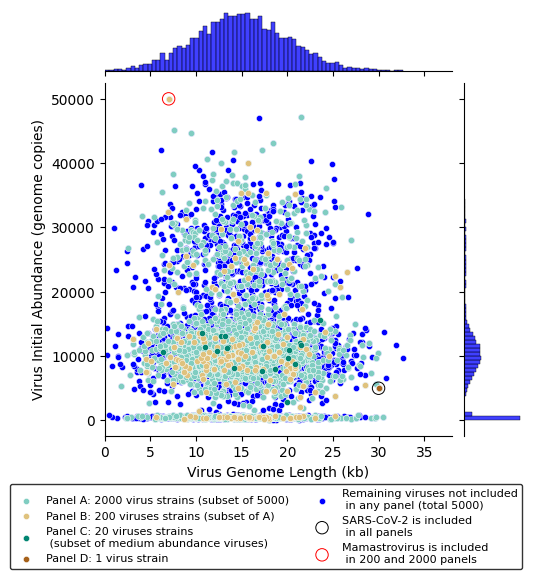

In [ ]:
# Create joint marginal distribution plot for all human viruses
joint_plot = sns.jointplot(x='genome_length', y='initial_gc_human', data=data_human_virus,color='blue', kind='scatter', s=20, marginal_kws=dict(bins=80, fill=True), height=5, xlim=(0, 38000),label="Remaining viruses not included\n in any panel (total 5000)")

# ColorBrewer2 codes for colors
color_panel_a = '#80cdc1'  # Green
color_panel_b = '#dfc27d'  # Light green
color_panel_c = '#018571'  # Blue
color_panel_d = '#a6611a'  # Dark blue

# Plot other datasets with ColorBrewer2 colors
sns.scatterplot(x=genome_lengths_4, y=gc_initials_4, color=color_panel_a, label='Panel A: 2000 virus strains (subset of 5000)', marker='o', s=20, ax=joint_plot.ax_joint)
sns.scatterplot(x=genome_lengths_3, y=gc_initials_3, color=color_panel_b, label='Panel B: 200 viruses strains (subset of A)', marker='o', s=20, ax=joint_plot.ax_joint)
sns.scatterplot(x=genome_lengths_2, y=gc_initials_2, color=color_panel_c, label='Panel C: 20 viruses strains\n (subset of medium abundance viruses)', marker='o', s=20, ax=joint_plot.ax_joint)
sns.scatterplot(x=genome_lengths_1, y=gc_initials_1, color=color_panel_d, label='Panel D: 1 virus strain', marker='o', s=20, ax=joint_plot.ax_joint)

# Scatter plot for SARS-CoV-2 and Mamastrovirus
sns.scatterplot(x=[SARS_CoV_2_length], y=[SARS_CoV_2_gc], color='none', edgecolor='black',label='SARS-CoV-2 is included\n in all panels', marker='o', s=80, ax=joint_plot.ax_joint)
sns.scatterplot(x=[Mamastrovirus_length], y=[Mamastrovirus_gc], color='none', edgecolor='red', label='Mamastrovirus is included\n in 200 and 2000 panels', marker='o', s=80, ax=joint_plot.ax_joint)

# Set labels and title
joint_plot.set_axis_labels('Virus Genome Length (kb)', 'Virus Initial Abundance (genome copies)')
#joint_plot.fig.suptitle('Characteristics of 5000 virus strains in modeled wastewater sample', y=1.02, fontweight='bold')

# Show legend
handles, labels = joint_plot.ax_joint.get_legend_handles_labels()
ordered_labels = ['Panel A: 2000 virus strains (subset of 5000)', 'Panel B: 200 viruses strains (subset of A)', 'Panel C: 20 viruses strains\n (subset of medium abundance viruses)', 'Panel D: 1 virus strain', "Remaining viruses not included\n in any panel (total 5000)",'SARS-CoV-2 is included\n in all panels', 'Mamastrovirus is included\n in 200 and 2000 panels']
ordered_handles = [handles[labels.index(label)] for label in ordered_labels]
joint_plot.ax_joint.legend(ordered_handles, ordered_labels, fontsize=8, bbox_to_anchor=(1.22,-0.12), ncol=2,edgecolor='black')

# Modify x-axis tick labels
x_ticks = joint_plot.ax_joint.get_xticks()
joint_plot.ax_joint.set_xticklabels([str(int(x/1000)) for x in x_ticks])

plt.savefig('/content/drive/My Drive/Colab Notebooks/modeling/distribution.png',  bbox_inches='tight',dpi=300)
# Show plot
plt.show()

**Define the mass_ratios and different sequencing panel sizes**

In [ ]:
mass_ratios = [10**(-i) for i in range(0, 9)]
size = [1,20,200,2000]

**Generating the output matrix including the total targeted virus %, each virus %, RPKM and minimal sequencing depth**

In [ ]:
import pandas as pd
# reconfirm the enrichment and depletion fold
enrichment_fold = 100
depletion_fold = 100

# Initialize lists to store results for each subset
subset_data = []

# Iterate over each mass ratio
for mass_ratio in mass_ratios:
    # Calculate total gc for mass ratio
    virus_total_ng, total_ng, total_gc = calculate_total_gc(gc_initials, genome_lengths, mass_ratio)

    # Iterate over each subset size
    for i in range(4):  # Adjusted the range to directly iterate over the size list
        # Generate subset data
        subset_genome_lengths, subset_gc_initials = globals()[f'genome_lengths_{i+1}'], globals()[f'gc_initials_{i+1}']
        size_i = size[i]

        # Calculate background reads
        targeted_virus_ng_i, background_ng_i, background_gc_i, background_reads_i,non_targeted_virus_ng_i = calculate_background_reads(subset_genome_lengths, subset_gc_initials, total_ng)

        # Calculate abundance
        total_targeted_virus_abundance_i, total_virus_abundance_i,relative_abundances_i, rpkms_i = calculate_abundance_RPKM(subset_genome_lengths, subset_gc_initials, background_reads_i, targeted_virus_ng_i,non_targeted_virus_ng_i)

        # Calculate sequencing depth
        final_sequencing_depth_i, sequencing_depths_i = calculate_sequencing_depth(relative_abundances_i, subset_genome_lengths, coverage_breadth, coverage_depth)

        # Store results for this subset with mass ratio information
        subset_data.append({
            'mass_ratio': mass_ratio,
            'size of subset': size_i,
            'background_ng':background_ng_i,
            'targeted_virus_ng': targeted_virus_ng_i,
            'background_reads': background_reads_i,
            'total_targeted_virus_abundance': total_targeted_virus_abundance_i,
            'minimal_sequence_depth': final_sequencing_depth_i,
            'relative_abundance (%)':relative_abundances_i,
            'sequencing_depths':sequencing_depths_i,
            'genome_lengths':subset_genome_lengths,
            "gc_initials":subset_gc_initials
        })

# Create DataFrame for the output
df = pd.DataFrame(subset_data)
df = df[['mass_ratio', 'size of subset', 'background_ng','targeted_virus_ng', 'background_reads', 'total_targeted_virus_abundance', 'minimal_sequence_depth',"relative_abundance (%)","sequencing_depths","genome_lengths","gc_initials"]]
print(enrichment_fold)
df.head()

100


,mass_ratio,size of subset,background_ng,targeted_virus_ng,background_reads,total_targeted_virus_abundance,minimal_sequence_depth,relative_abundance (%),sequencing_depths,genome_lengths,gc_initials
0,1.0,1,0.884350,0.000080,3.314098e+07,47.512728,5682.687799,[47.512728055581356],[5682.687798607323],[30000],[5000]
1,1.0,20,0.882620,0.001810,3.307613e+07,95.351191,20603.463458,"[4.325672593036803, 3.5527445738230767, 3.7580...","[28100.39210765845, 27902.340700278117, 29539....","[13505.899554853979, 11014.432168875097, 12334...","[11393.920813917353, 11474.795106042739, 10838..."
2,1.0,200,0.867084,0.017346,3.249392e+07,99.502619,58797.068375,"[0.009100182296378217, 0.24583439851835767, 0....","[5570783.053677772, 646325.4257770468, 332310....","[5632.793480226916, 17654.335810335746, 11187....","[527.7271418426154, 4548.565322504835, 8846.71..."
3,1.0,2000,0.710841,0.173589,2.663874e+07,99.959067,585711.075083,"[0.04603004919811871, 0.023922472845227888, 0....","[2170180.720589649, 3534979.693185777, 3154637...","[11099.280593061141, 9396.161746518752, 16532....","[13494.523048843786, 8284.504097889414, 9283.3..."
4,0.1,1,4.864287,0.000080,1.822889e+08,14.131688,19105.997892,[14.131687940164845],[19105.997892340274],[30000],[5000]


**Generate the output matrix when enrichment and depletion fold equal one (mimic the unenriched metagenomic sequencing)**

In [ ]:
# Initialize lists to store results for each subset
subset_data_2 = []

# input new enrichment and depletion fold
enrichment_fold = 1
depletion_fold = 1

# Iterate over each mass ratio
for mass_ratio in mass_ratios:
    # Calculate total gc for mass ratio
    virus_total_ng, total_ng, total_gc = calculate_total_gc(gc_initials, genome_lengths, mass_ratio)

    # Iterate over each subset size
    for i in range(4):  # Adjusted the range to directly iterate over the size list
        # Generate subset data
        subset_genome_lengths, subset_gc_initials = globals()[f'genome_lengths_{i+1}'], globals()[f'gc_initials_{i+1}']
        size_i = size[i]

        # Calculate background reads
        targeted_virus_ng_i, background_ng_i, background_gc_i, background_reads_i,non_targeted_virus_ng_i = calculate_background_reads(subset_genome_lengths, subset_gc_initials, total_ng)

        # Calculate abundance
        total_targeted_virus_abundance_i, total_virus_abundance_i,relative_abundances_i, rpkms_i = calculate_abundance_RPKM(subset_genome_lengths, subset_gc_initials, background_reads_i, targeted_virus_ng_i,non_targeted_virus_ng_i)

        # Calculate sequencing depth
        final_sequencing_depth_i, sequencing_depths_i = calculate_sequencing_depth(relative_abundances_i, subset_genome_lengths, coverage_breadth, coverage_depth)

        # Store results for this subset with mass ratio information
        subset_data_2.append({
            'mass_ratio': mass_ratio,
            'size of subset': size_i,
            'background_ng':background_ng_i,
            'targeted_virus_ng': targeted_virus_ng_i,
            'background_reads': background_reads_i,
            'total_targeted_virus_abundance': total_targeted_virus_abundance_i,
            'minimal_sequence_depth': final_sequencing_depth_i,
            'relative_abundance (%)':relative_abundances_i,
            'sequencing_depths':sequencing_depths_i,
            'genome_lengths':subset_genome_lengths,
            "gc_initials":subset_gc_initials
        })

# Create DataFrame for the output
df_2 = pd.DataFrame(subset_data_2)
df_2 = df_2[['mass_ratio', 'size of subset', 'background_ng','targeted_virus_ng', 'background_reads', 'total_targeted_virus_abundance', 'minimal_sequence_depth',"relative_abundance (%)","sequencing_depths","genome_lengths","gc_initials"]]
print(depletion_fold)
df_2.head()

1


,mass_ratio,size of subset,background_ng,targeted_virus_ng,background_reads,total_targeted_virus_abundance,minimal_sequence_depth,relative_abundance (%),sequencing_depths,genome_lengths,gc_initials
0,1.0,1,0.884350,0.000080,3.314098e+09,0.009051,2.982958e+07,[0.009051418700125661],[29829577.986073233],[30000],[5000]
1,1.0,20,0.882620,0.001810,3.307613e+09,0.204689,9.597802e+06,"[0.00928585949881799, 0.007626625972759657, 0....","[13090128.706896598, 12997869.55253113, 137606...","[13505.899554853979, 11014.432168875097, 12334...","[11393.920813917353, 11474.795106042739, 10838..."
2,1.0,200,0.867084,0.017346,3.249392e+09,1.961296,2.982958e+06,"[0.00017937365421447998, 0.004845640774845402,...","[282623117.3359787, 32790095.19604577, 1685911...","[5632.793480226916, 17654.335810335746, 11187....","[527.7271418426154, 4548.565322504835, 8846.71..."
3,1.0,2000,0.710841,0.173589,2.663874e+09,19.627208,2.982958e+06,"[0.00903811298119733, 0.004697236177919002, 0....","[11052475.83708749, 18003236.906885415, 160661...","[11099.280593061141, 9396.161746518752, 16532....","[13494.523048843786, 8284.504097889414, 9283.3..."
4,0.1,1,4.864287,0.000080,1.822889e+10,0.001646,1.640627e+08,[0.0016457124909319387],[164062678.92340273],[30000],[5000]


**Organize the final dataset for figure 1(a) (Total targeted virus % by mass ratio, including four enriched probe-capture panels and one unenriched 1 virus panel exapmle )**

In [ ]:
data_1 = df[['mass_ratio', 'size of subset', 'total_targeted_virus_abundance', 'minimal_sequence_depth']].copy()
data_1['size of subset'] = data_1['size of subset'].replace({1: 'Panel D: 1 target', 20: 'Panel C: 20 targets', 200: 'Panel B: 200 targets', 2000: 'Panel A: 2000 targets'})
data_1_unenriched = df_2[['mass_ratio', 'size of subset', 'total_targeted_virus_abundance', 'minimal_sequence_depth']].copy()
data_1_unenriched['size of subset'] = data_1_unenriched['size of subset'].replace({1: 'Unenriched 1 virus target', 20: '20 viruses panel unenriched', 200: '200 viruses panel unenriched', 2000: '2000 viruses panel unenriched'})
data_1_unenriched = data_1_unenriched[data_1_unenriched["size of subset"]=='Unenriched 1 virus target']
data_1_final = data_1_final = pd.concat([data_1, data_1_unenriched])
print(data_1_final['size of subset'].unique())
data_1_final = data_1_final.melt(id_vars=['mass_ratio', 'size of subset'],
                    value_vars=['total_targeted_virus_abundance', 'minimal_sequence_depth'],
                    var_name='variable', value_name='value')
data_1_final["value"]=data_1_final["value"].astype(float)
data_1_final.head()

['Panel D: 1 target' 'Panel C: 20 targets' 'Panel B: 200 targets'
 'Panel A: 2000 targets' 'Unenriched 1 virus target']


,mass_ratio,size of subset,variable,value
0,1.0,Panel D: 1 target,total_targeted_virus_abundance,47.512728
1,1.0,Panel C: 20 targets,total_targeted_virus_abundance,95.351191
2,1.0,Panel B: 200 targets,total_targeted_virus_abundance,99.502619
3,1.0,Panel A: 2000 targets,total_targeted_virus_abundance,99.959067
4,0.1,Panel D: 1 target,total_targeted_virus_abundance,14.131688


**Organize the dataset for Figure 1 (b) and (c) of SARS-CoV-2**

In [ ]:
new_data = df[["mass_ratio","size of subset","relative_abundance (%)","sequencing_depths","genome_lengths","gc_initials"]].copy()
new_data = new_data.explode(['relative_abundance (%)', 'sequencing_depths', 'genome_lengths', 'gc_initials'])
# Reset index
new_data = new_data.reset_index(drop=True)
# Find SARS-CoV-2 data
SARS_CoV_2 = new_data[(new_data["genome_lengths"] == 30000) & (new_data["gc_initials"] == 5000)]
# Replace the size of subset values with labels
SARS_CoV_2['size of subset'] = SARS_CoV_2['size of subset'].replace({1: 'Panel D: 1 target', 20: 'Panel C: 20 targets', 200: 'Panel B: 200 targets', 2000: 'Panel A: 2000 targets'})
# Melt the DataFrame
data_2 = SARS_CoV_2.melt(id_vars=['mass_ratio', 'size of subset'],
                    value_vars=['relative_abundance (%)', 'sequencing_depths'],
                    var_name='variable', value_name='value')
data_2["value"]=data_2["value"].astype(float)

<ipython-input-32-c3e8873bebbe>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SARS_CoV_2['size of subset'] = SARS_CoV_2['size of subset'].replace({1: 'Panel D: 1 target', 20: 'Panel C: 20 targets', 200: 'Panel B: 200 targets', 2000: 'Panel A: 2000 targets'})


# Output Figures:

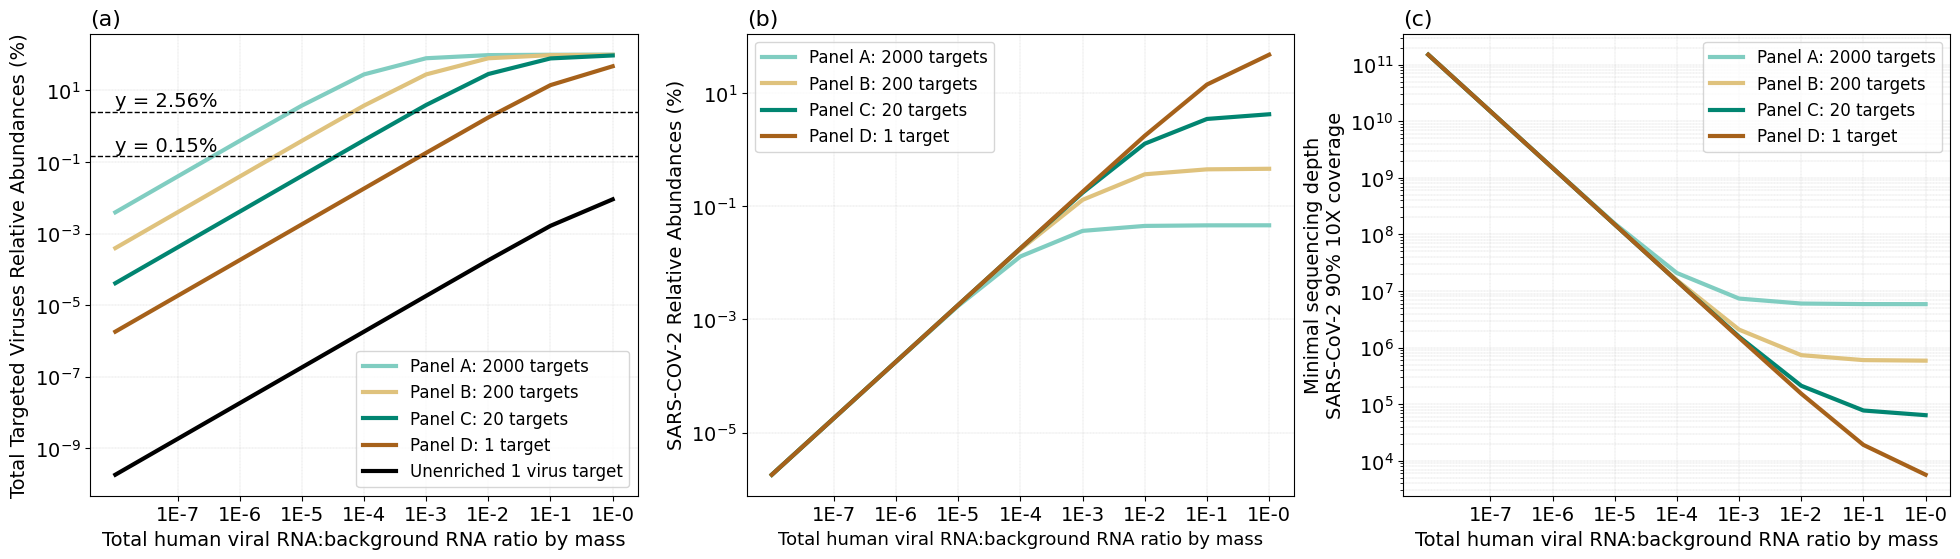

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Define colors for subsets
subset_colors = {
    'Panel A: 2000 targets': '#80cdc1',
    'Panel B: 200 targets': '#dfc27d',
    'Panel C: 20 targets': '#018571',
    'Panel D: 1 target':'#a6611a'
}

# Plotting
fig, axs = plt.subplots(1, 3, figsize=(24, 6), sharey=False)

# Extract data for total targeted virus abundance
virus_abundance_data = data_1_final[data_1_final['variable'] == 'total_targeted_virus_abundance']

# Plot for total virus abundance
for subset, subset_data in virus_abundance_data.groupby('size of subset'):
    axs[0].plot(subset_data['mass_ratio'], subset_data['value'], label=f"{subset}", color=subset_colors.get(subset, 'black'), linewidth=3)

axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].set_xlabel('Total human viral RNA:background RNA ratio by mass', fontsize=14)  # Adjusted font size
axs[0].set_ylabel('Total Targeted Viruses Relative Abundances (%)', fontsize=14)  # Adjusted font size
axs[0].set_title('(a)', loc='left', fontdict={'fontsize': 16})
axs[0].legend(fontsize=12, loc='lower right', bbox_to_anchor=(1, 0))
axs[0].grid(True, which='both', linestyle='--', linewidth=0.2)
axs[0].tick_params(axis='both', which='major', labelsize=14)  # Adjusted tick font size

# Set x-axis ticks as 1E-1, 1E-2 to 1E-8
ticks = [10**(-i) for i in range(0, 8)]
axs[0].set_xticks(ticks)
axs[0].set_xticklabels([f'1E-{i}' for i in range(0, 8)], fontsize=14)  # Adjusted tick font size

# Add horizontal lines for total virus abundance
axs[0].axhline(y=0.15, linestyle='--', color='black', label='y = 0.15', linewidth=1) # Adjusted line width
axs[0].text(0.00000001, 0.15 + 0.05, 'y = 0.15%', color='black', fontsize=14, ha='left')

axs[0].axhline(y=2.56, linestyle='--', color='black', label='y = 2.56', linewidth=1) # Adjusted line width
axs[0].text(0.00000001, 2.56 + 1, 'y = 2.56%', color='black', fontsize=14, ha='left')

# Plot relative abundance of SARS-CoV-2
relative_abundance_data = data_2[data_2['variable'] == 'relative_abundance (%)']
for subset, subset_data in relative_abundance_data.groupby('size of subset'):
    axs[1].plot(subset_data['mass_ratio'], subset_data['value'], label=subset, color=subset_colors.get(subset, 'black'), linewidth=3)

axs[1].set_yscale('log')
axs[1].set_xscale('log')
axs[1].set_ylabel('SARS-COV-2 Relative Abundances (%)', fontsize=14)  # Adjusted font size
axs[1].set_title('(b)', loc='left', fontdict={'fontsize': 16})
axs[1].legend(fontsize=12)
axs[1].set_xlabel('Total human viral RNA:background RNA ratio by mass', fontsize=13)  # Adjusted font size
ticks = [10**(-i) for i in range(0, 8)]
axs[1].set_xticks(ticks)
axs[1].set_xticklabels([f'1E-{i}' for i in range(0, 8)], fontsize=14)  # Adjusted tick font size
axs[1].grid(True, which='both', linestyle='--', linewidth=0.2)
axs[1].tick_params(axis='both', which='major', labelsize=14)  # Adjusted tick font size

# Plot sequencing depths
sequencing_depth_data = data_2[data_2['variable'] == 'sequencing_depths']
for subset, subset_data in sequencing_depth_data.groupby('size of subset'):
    axs[2].plot(subset_data['mass_ratio'], subset_data['value'], label=subset, color=subset_colors.get(subset, 'black'), linewidth=3)

axs[2].set_yscale('log')
axs[2].set_xscale('log')
axs[2].set_xlabel('Total human viral RNA:background RNA ratio by mass', fontsize=14)  # Adjusted font size
axs[2].set_ylabel('Minimal sequencing depth\nSARS-CoV-2 90% 10X coverage', fontsize=14)  # Adjusted font size
axs[2].set_title('(c)', loc='left', fontdict={'fontsize': 16})
axs[2].legend(fontsize=12)
ticks = [10**(-i) for i in range(0, 8)]
axs[2].set_xticks(ticks)
axs[2].set_xticklabels([f'1E-{i}' for i in range(0, 8)], fontsize=14)  # Adjusted tick font size
axs[2].grid(True, which='both', linestyle='--', linewidth=0.2)
axs[2].tick_params(axis='both', which='major', labelsize=14)  # Adjusted tick font size

plt.savefig('/content/drive/My Drive/Colab Notebooks/modeling/results.png',  bbox_inches='tight',dpi=300)
plt.savefig('/content/drive/My Drive/Colab Notebooks/modeling/results.svg',  bbox_inches='tight')
#plt.tight_layout()
plt.show()



## Part 2: Predicting the detection probability of targeted viruses




---





*   **Description:** This model was used to calculate the detection probability of targeted viruses under various positive detection thresholds, considering the given sequencing depth and the relative abundances of the targeted viruses in the generated sequencing pool after library preparation.

*   **Assumptions:**
    *   n: sequencing depth (set to 10000 here)
    *   k: required positive detection threshold (k reads from targeted viruses)
    *   p: probability of sequenced reads were from targeted viruses (this equals to the relative abundances (%) of targeted viruses in the sequencing pool divided by 100
    *   Probability of detection follow the binormial distribution
    
*   **Positive Detection Threshold:**
  *   Condition 1: At least k reads from the targeted viruses should be present within the sequencing depth of n.
  *   Condition 2: At least k reads from at least 3 different regions of the targeted viruses should be present within the sequencing depth of n.


**Condition 1**: detect at least k reads of targeted viruses

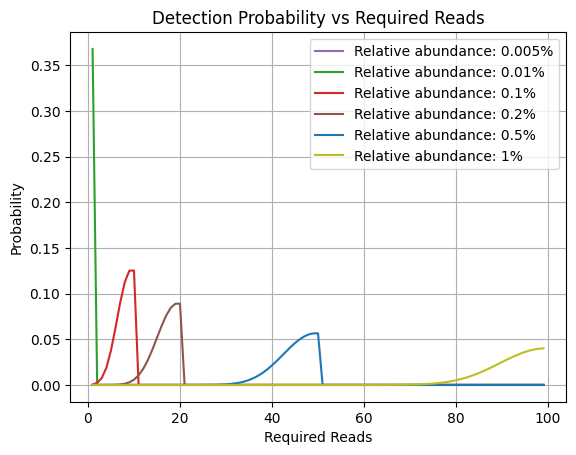

In [6]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import random

def calculate_detection_P(relative_abundances, required_reads, sequencing_depth):
    '''
    It returns Probabilities,
    which represent the detection probability of a virus with a known relative abundance at a given sequencing depth,
    considering various required reads for positive detection. If the virus has less than 1 reads, the detection probability = 0
    '''
    n = sequencing_depth
    Probabilities = []
    for p in relative_abundances:
        for k in required_reads:
            if p/100 * n < 1:
                Probability = 0
            if p == 0 or p/100 * n < k:
                Probability = 0
            else:
                Probability = (math.factorial(n) / (math.factorial(k) * math.factorial(n - k))) * (p/100)**k * (1 - p/100)**(n - k)
            Probabilities.append(Probability)
    return Probabilities


# Define parameters
relative_abundances = [0.005,0.01, 0.1, 0.2,0.5,1]  # relative abundances of targeted viruses
required_reads = range(1, 100)  # required reads range from 1 to 10
sequencing_depth = 10000  # sequencing depth

# Calculate probabilities
probabilities = calculate_detection_P(relative_abundances, required_reads, sequencing_depth)

# Randomly choose colors from a predefined color palette
color_palette = list(mcolors.TABLEAU_COLORS.keys())
colors = random.sample(color_palette, len(relative_abundances))

# Plotting
for i, p in enumerate(relative_abundances):
    plt.plot(required_reads, probabilities[i*len(required_reads):(i+1)*len(required_reads)], label=f'Relative abundance: {p}%', color=colors[i])

plt.xlabel('Required Reads')
plt.ylabel('Probability')
plt.title('Detection Probability vs Required Reads')
plt.legend()
plt.grid(True)
plt.show()

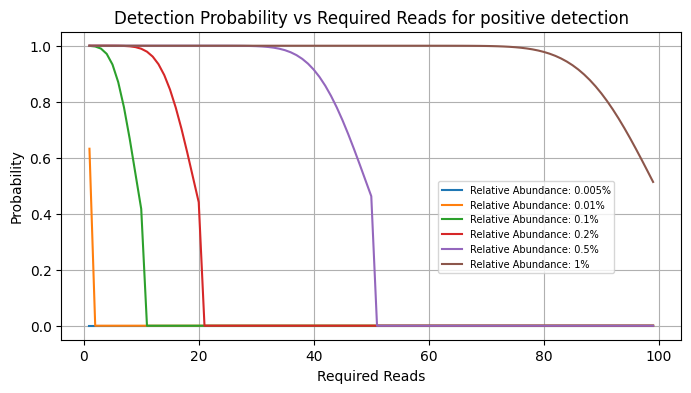

In [2]:
# Calculate probabilities
probabilities = calculate_detection_P(relative_abundances, required_reads, sequencing_depth)

# Reshape probabilities for each relative abundance
probabilities_reshaped = np.array(probabilities).reshape(len(relative_abundances), -1)
probabilities_reshaped = pd.DataFrame(probabilities_reshaped)
probabilities_reshaped = probabilities_reshaped.T

# Calculate the accumulated probability to represent at least k reads instead of right at k reads
accumulated_values = 1-probabilities_reshaped.cumsum()

# Reset accumulated values to 0 where any row in the column is 0 (whenever probability =0)
for col in accumulated_values.columns:
    accumulated_values.loc[probabilities_reshaped[col] == 0, col] = 0
accumulated_values['required_reads'] = required_reads

# Convert relative abundances to strings
relative_abundances_str = [str(value) for value in relative_abundances]

# Define the new column names
new_column_names = {i: p for i, p in enumerate(relative_abundances_str)}

# Rename the columns
accumulated_values = accumulated_values.rename(columns=new_column_names)

# Reshape the dataframe
accumulated_values.set_index('required_reads', inplace=True)
accumulated_values = accumulated_values.stack().reset_index()
accumulated_values.columns = ['required_reads', 'Relative_Abundance', 'Values']

# Plotting
plt.figure(figsize=(8, 4))
for rel_abundance, group in accumulated_values.groupby('Relative_Abundance'):
    plt.plot(group['required_reads'], group['Values'], label=f'Relative Abundance: {rel_abundance}%')

plt.xlabel('Required Reads')
plt.ylabel('Probability')
plt.title('Detection Probability vs Required Reads for positive detection')
plt.legend(fontsize=7, loc='lower right', bbox_to_anchor=(0.9, 0.2))
plt.grid(True)
plt.show()

**Condition 2:** Detect k reads, which align at least 3 different regions of targeted viruses

In [3]:
import math

# Define the function to calculate p_diff_regions
def calculate_p_diff_segment(genome_length, segment_length, num_regions_required):
    num_segments = genome_length // segment_length
    p_diff_regions = 1
    for i in range(num_regions_required):
        p_diff_regions *= (num_segments - i) / num_segments
    return p_diff_regions

def calculate_detection_P_segment(relative_abundances, required_reads, sequencing_depth,num_regions_required,genome_length,segment_length):
    n = sequencing_depth
    Probabilities = []
    p_diff_regions = calculate_p_diff_segment(genome_length, segment_length, num_regions_required)
    for p in relative_abundances:
        for k in required_reads:
            if p/100 * n < 1:
                Probability = 0
            if p == 0 or p/100 * n < k:
                Probability = 0
            else:
                Probability =  (math.factorial(n) / (math.factorial(k) * math.factorial(n - k))) * (p/100)**k * (1 - p/100)**(n - k)
            Probabilities.append(Probability)
    return Probabilities


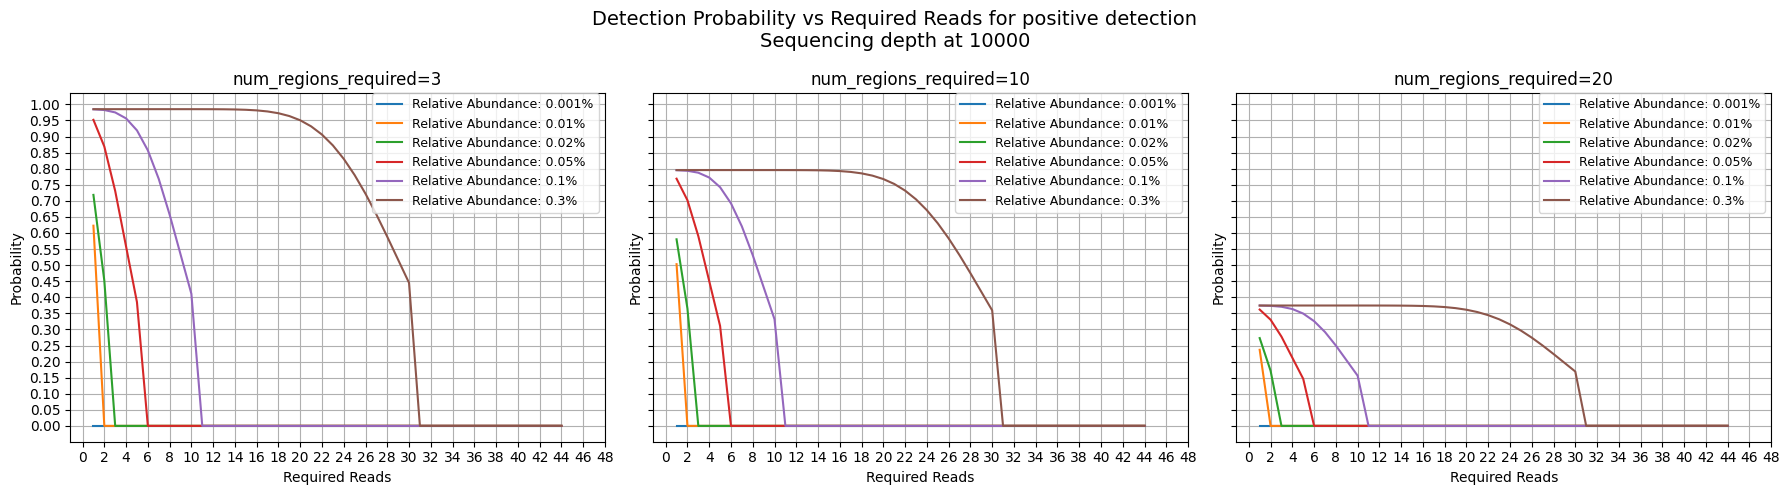

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Example parameters
relative_abundances = [0.001, 0.01, 0.02, 0.05, 0.1, 0.3]
genome_length = 30000
segment_length = 150
sequencing_depth = 10000
required_reads = range(1, 45)
num_regions_values = [3, 10, 20]

fig, axes = plt.subplots(1, len(num_regions_values), figsize=(18, 5), sharey=True)

for i, num_regions_required in enumerate(num_regions_values):
    p_diff_regions = calculate_p_diff_segment(genome_length, segment_length, num_regions_required)
    Probabilities = calculate_detection_P_segment(relative_abundances, required_reads, sequencing_depth, num_regions_required, genome_length, segment_length)

    # Reshape probabilities for each relative abundance
    probabilities_reshaped = np.array(Probabilities).reshape(len(relative_abundances), -1)
    probabilities_reshaped = pd.DataFrame(probabilities_reshaped)
    probabilities_reshaped = probabilities_reshaped.T

    accumulated_values = p_diff_regions*(1 - probabilities_reshaped.cumsum())

    # Reset accumulated values to 0 where any row in the column is 0
    for col in accumulated_values.columns:
        accumulated_values.loc[probabilities_reshaped[col] == 0, col] = 0

    accumulated_values['required_reads'] = required_reads
    relative_abundances_str = [str(value) for value in relative_abundances]

    new_column_names = {i: p for i, p in enumerate(relative_abundances_str)}

    accumulated_values = accumulated_values.rename(columns=new_column_names)

    accumulated_values.set_index('required_reads', inplace=True)
    accumulated_values = accumulated_values.stack().reset_index()
    accumulated_values.columns = ['required_reads', 'Relative_Abundance', 'Values']

    # Plotting
    for rel_abundance, group in accumulated_values.groupby('Relative_Abundance'):
        axes[i].plot(group['required_reads'], group['Values'], label=f'Relative Abundance: {rel_abundance}%')

    axes[i].set_xlabel('Required Reads')
    axes[i].set_ylabel('Probability')
    axes[i].set_yticks([i / 20 for i in range(21)])
    axes[i].set_xticks([i for i in range(0, 50, 2)])
    axes[i].set_title(f'num_regions_required={num_regions_required}')
    axes[i].legend(fontsize=9, loc='lower right', bbox_to_anchor=(1, 0.64))
    axes[i].grid(True)

plt.suptitle('Detection Probability vs Required Reads for positive detection\nSequencing depth at 10000', fontsize=14)
plt.tight_layout()
plt.show()
